In [ ]:
%load_ext autoreload
%autoreload 2

# Anomaly detection with autoencoder

Today, we will detect anomalies in another dataset containing devices logs. The devices are supposed to send a payload every hour. As we will see, some devices disappear from the network from time to time. We will build an algorithm to predict these failures: an autoencoder.  
An autoencore is a particular type of Feedforward Neural Networks (FNN). So, let us first have a look on what a FNN is. 

## Feedforward Neural Network 

The explanations on FNN are given in the PDF file "FNN-intro.pdf". Try to understand the main ideas in this paper, but we keep in mind that the topic of Neural Nework is very large and can be difficult to fully understand 
at first sight.

Here is a summary of the PDF.

The FNN aims to build a **prediction function** based on a **labelled data set**.
The data set $D$ is composed of points $p=(x,y)$ where $x \in \mathbb{R}^{I}$ is the "input" and $y \in \mathbb{R}^{O}$ is the "label" (or output). For example, the MNIST data base is composed of $x$ values that are tables of $28 \times 28 = 784$ pixels that represent a black and white handwritten digit and of $y$ values of digits represented as an array of $9$ zeros with a $1$ in the index that corresponds to the written digit. For example a $3$ will be represented as $[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]$.

A FNN is composed of an input layer, of $(L-1)\in \mathbb{N}$ hidden layers and of an output layer. We note the dimension of layer $l$ as $n_l$.  
For coherence with the data, we have that the first layer ($l=0$) is of the same size that the input and the last layer ($l=L$) is of the size of the output. So, we have $n_0=I$ and $n_L=O$.

<img src="./images/FNN.jpg" alt="FNN" width="500"/>
(src: https://neuralnetworksanddeeplearning.com/chap1.html)

#### Feedforward

Let us take a point $p=(x,y)$ where $x$ is the input and $y$ is the label (output, the result to predict).
The prediction is the value of the last layer.

The fist layer is equal to the input

$$
a^{(0)} = x
$$

The value of the layer $l$ is a function of the previous layer $(l-1)$, defined as 

$$
z^{(l)}_j = \sum_{k} w^{(l)}_{jk} a^{(l-1)}_k + b^{(l)}_j
$$

$$
a^{(l)}_j = \sigma(z^{(l)}_j)
$$

or in matrix notation,
$$
a^{(l)} = \sigma ( w^{(l)} \cdot a^{(l-1)} + b^{(l)}).
$$

where $\sigma$ is the activation function. Here we will use the sigmoid function,

$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$
We can simply compute the derivative function
$$
\sigma '(z) =  \frac{e^{-z}}{(1 + e^{-z})^{2}} = \sigma(z) (1 - \sigma(z)).
$$


#### Learning

The process of learning starts with randomly initialized parameters $P=(w,b)$ (weights and biases). Then at each step (this step is called an **epoch**), we adjust the parameters to $P \rightarrow P'$ that will give a better prediction on the training data.

For that purpose we define the **error** as the distance between the label valyes $y$ and the prediction $a^{L}$.  
Here is the value of the error for one point $p$. 
$$
C_p = \sum_{j=0}^{n_L -1} (a^{(L)}_j - y_j)^2
$$
The total error is the mean of all the errors, 

$$
C = \frac{1}{|D|} \sum_{p \in D} C_p
$$

This adjustment is done by the **gradient descent**. The idea is to adjust the parameters in the **direction that minimize the most the error**. The direction that locally minimise the error is the direction of the negative gradient of $C$ with respect to the parameters $P$.  
So, at each epoch we adjust the parameters as

$$ P' = P - \alpha \nabla C,$$

where $\alpha$ is the **learning rate**. It defines how fast the parameters will be adjusted.  

Note that the gradient is the vector of the partial derivatives: 

$$
\nabla C = \left(\frac{\partial C}{\partial w^{(1)}_{11}}, \dots, \frac{\partial C}{\partial b^{(1)}_1}, \dots \right)
$$

Here, we provide you, by omitting computation, the equations that gives us the gradient,

\begin{align}
\frac{\partial C_p}{\partial w^{(l)}} & = 
\frac{\partial C_p}{\partial z^{(l)}} \cdot (a^{(l-1)})^{T} , \\
\frac{\partial C_p}{\partial b^{(l)}} & = 
\frac{\partial C_p}{\partial z^{(l)}}, \\
\frac{\partial C_p}{\partial z^{(L)}} & = 2 (a^{(L)} - y) \odot \sigma ' (z^{(L)}), \\
\frac{\partial C_p}{\partial z^{(l)}} & =
\left( (w^{(l+1)})^{T} \cdot \frac{\partial C_p}{\partial z^{(l+1)}} \right) \odot \sigma ' (z^{(l)})  && l < L.
\end{align}


## Autoencoder

An autoencoder (AE) is a type of neural network that gets an input and learns to rebuild it, instead of mapping this input to an ouput as a classical NN would do.

Moreover, we generally assume that the hidden layers are smaller than the input/output layers. So it will in fact **compress** the data and then **decompress** it again to try to reconstruct the inital input.

This seems to be useless, however scientists have found some ways to use it. One of them is the **Outlier Detection**. The idea is the following, first it learns the **autoencode the data**, then each point is sent by the feedforward to its image and we compute its loss (error),

$$
C_x = |x - x'|².
$$

The points with a **high loss** are those who are **not well reconstructed** by the Autoencoder and so they can be seen as **outliers**. 

![AE](./images/Toad.png)

(src: https://medium.com/themlblog/deep-autoencoders-using-tensorflow-4f68655c8d08)

The idea behind the use of AE as anomaly detection algorithm is quite simple:

- an AE that has been trained on inliners will be able to rebuild inliners but not outliers;
- the preparation of the data to train an AE is often more straightforward: a classical neural network will require supervision, aka a labeled dataset (with label that actually make sense) while an AE is unsupervised and can be directly used to compute the difference between the input and the output.

We will build our autoencoders using "dummy" training data points. We have generated randomly distributed normal data of size 300 in 3 dimensions. We use this data instead of logs to make sure our algorithm learns while keeping the computations very fast.

We will implement our AE using PyTorch (https://pytorch.org/). PyTorch offers many tools to implement algorithms, ranging from low level functions (ex: matrices multiplication, broadcasting) to pre-made networks expecting only a forward method (eg: https://pytorch.org/tutorials/beginner/nn_tutorial.html#switch-to-cnn).

We will go for the low level implementation. The PyTorch low level are the same as numpy's ones, except that `np.ndarray` is replaced by `torch.Tensor`. The syntax of matrix multiplications, element wise addition/multiplication etc. are identical.

**Warning**  

These are quite simple models of FNN and Autoencoder and they are far from the current state of art.

The implementation that we propose here is certainly not a good way to do Outlier Detection with Autoencoder. To do it well we should spend much more time to specify our Autoencoder activation function, error (loss) function and a large set of different variations that we can apply to a Neural Network. The aim here is to present the global idea about how a Neural Network can be usefull in an unusual context and at the same time a very clever way to do Outlier Detection. Isn't that amazing?

In [3]:
# you do not need to change the content of this cell
# load the modules we need
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import random
from typing import Any, List, Optional, Tuple, Union
import torch

In [4]:
# you do not need to change the content of this cell
# load the training data
training_data = torch.load('./data/training_data_points.pt')

Here are some guidelines to implement the autoencoder. We will create 4 python classes:
    
1) Network: contains the methods that are common to both a classical Neural Network and an autoencoder.

2) Autoencoder: contains the methods that are proper to an autoencoder.
    
3) Sigmoid: the sigmoid activation function which we will use for *all* layers except the output layer. 
    
    Since the principle of a NN is a gradient descent due to the feedforward and backpropagation functions, our ActivationFunction class will have two methods: compute and differentiate. The same holds true for the CostFunction.

    Note that frameworks like PyTorch and Tensorflow use a Layer class that allows you to use a different activation function for each layer (along with other transformations like dropouts, masks, etc. that are out of the scope of this TD). For the sake of clarity, we will use the sigmoid activation function for all layers and pass it to the __init__ method of the Network class.
   
4) Mean squared error: the cost function we will apply to the output layer.

Refer to the pdf when implemeing your functions.

In [5]:
# you do not need to change the content of this cell
# here we define abstract classes for the activation and cost functions
# our clases will inherit their methods

class ActivationFunction(ABC):
    
    @abstractmethod
    def compute(self):
        pass
    
    @abstractmethod
    def differentiate(self):
        pass

    
class CostFunction(ABC):
    
    @abstractmethod
    def compute(self):
        pass
    
    @abstractmethod
    def differentiate(self):
        pass

In [129]:
# YOU MUST CHANGE THE CONTENT OF THIS CELL

class Sigmoid(ActivationFunction):
    
    @classmethod
    def compute(cls, z: torch.Tensor) -> torch.Tensor:
        # complete this
        return 1/(1+torch.exp(-z))

    @classmethod
    def differentiate(cls, z: torch.Tensor) -> torch.Tensor:
        # complete this
        return Sigmoid.compute(z)*(1-Sigmoid.compute(z))

We will use the mean squared error as our cost function: 



In [130]:
# YOU MUST CHANGE THE CONTENT OF THIS CELL

class MSE(CostFunction):
    
    @classmethod
    def compute(cls, a: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # complete this
        return torch.norm((a-y)**2)
    @classmethod
    def differentiate(cls, a: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return 2*(a-y)

We will now implement the Network class. You must complete the feedforward, backprop and GD methods.

The formulas are in the pdf.

In [366]:
# YOU MUST CHANGE THE CONTENT OF THIS CELL

class Network(ABC):
    
    def __init__(self, activation_function:ActivationFunction, cost_function:CostFunction, *layers:int) -> None:
        self.weights = [
            torch.rand(y, x, dtype=torch.float64) for x, y in zip(layers[:-1], layers[1:])
        ]
        self.biases = [
            torch.rand(y, 1, dtype=torch.float64) for y in layers[1:]
        ]
        self.activation_function = activation_function
        self.cost_function = cost_function
        
    @classmethod
    def get_batches(cls, X:List[torch.Tensor], Y:List[torch.Tensor], batch_size:int) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
        training_data = list(zip(X, Y))
        random.shuffle(training_data)
        X, Y = zip(*training_data)
        batchesX, batchesY = [], []
        for i in range(0, len(X), batch_size):
            batchesX.append(X[i:i+batch_size])
            batchesY.append(Y[i:i+batch_size])
        return batchesX, batchesY
    
    def feedforward(self, a:torch.Tensor) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
        # layers (activation)
        aL = [a]
        # layers (linear)
        zL = [a]
        # COMPLETE THIS
        for b, w in zip(self.biases,self.weights):
            zL.append(torch.tensordot(w, zL[-1],1)+b)
            aL.append(Sigmoid.compute(zL[-1]))
        return aL, zL
    
    def backprop(self, x:List[torch.Tensor], y:List[torch.Tensor], aL:List[torch.Tensor], zL:List[torch.Tensor]) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
        # initialize the gradient for this epoch
        dw = [torch.zeros(w.shape, dtype=torch.float64) for w in self.weights]
        db = [torch.zeros(b.shape, dtype=torch.float64) for b in self.biases]
        # COMPLETE THIS
        delta=2*(aL[-1]-y)*Sigmoid.differentiate(zL[-1])
        db[-1]=delta
        dw[-1]=torch.tensordot(delta,torch.t(aL[-2]),1)
        for l in range(2,len(layers)):
            z=zL[-l]
            sp=Sigmoid.differentiate(z)
            delta=torch.tensordot(torch.transpose(self.weights[-l+1],0,1),delta,1)*sp
            db[-l]=delta
            dw[-l]=torch.tensordot(delta,torch.t(aL[-l-1]),1)
        
        return dw, db
    
    def GD(self, X:Tuple[torch.Tensor], Y:Tuple[torch.Tensor], alpha:float) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
        # initialize gradients
        Edw = [torch.zeros(w.shape, dtype=torch.float64) for w in self.weights]
        Edb = [torch.zeros(b.shape, dtype=torch.float64) for b in self.biases]
        # descent
        for (x, y) in zip(X, Y):
            # feed forward
            aL, zL = self.feedforward(x)
            # backprop
            dw, db = self.backprop(x, y, aL, zL)
            # gradient update
            # COMPLETE THIS
        
            Edw = [edw+dnw for edw, dnw in zip(Edw, dw)]
            Edb = [edb+dnb for edb, dnb in zip(Edb, db)]
                
            
            
        return Edw, Edb
    
    def update_weigths_and_biases(self, Edw:List[torch.Tensor], Edb:List[torch.Tensor]) -> None:
        # apply
        
        self.weights = [w-0.12*dw_l for w, dw_l in zip(self.weights, Edw)]
        self.biases  = [b-0.12*db_l for b, db_l in zip(self.biases , Edb)]


The autoencoder class imply defines a train method and a few helpers for outliers detection.

Note the `self.GD(x, x, alpha)` line, where the training data is passed both as input and ouput.

In [367]:
# you do not need to change the content of this cell

class Autoencoder(Network):

    def autoencode(self, x) -> int:
        aL, zL = self.feedforward(x)
        return torch.norm(aL[-1] - x) ** 2
    
    def train(self, X:List[torch.Tensor], epochs:int=100, alpha:float=0.5, batch_size:int=100, test_data=None,
                  printEach:int=1, median:int=2, treshold:int=2) -> None:
        history = []
        for i in range(epochs):
            # stochastic?
            bacthX = self.get_batches(X, X, batch_size)[0] if batch_size else [X]
            for x in bacthX:
                Edw, Edb = self.GD(x, x, alpha)
                self.update_weigths_and_biases(Edw, Edb)
            # Print
            if(i%printEach == 0):
                if(test_data):
                    prediction = self.predict(X)
                    print("Epoch ", i, " of ", epochs, "  -> Average Distance: ", prediction)
                    history.append(prediction)
                else:
                    print("Epoch ", i, " of ", epochs)
        return history

    def predict(self, X):
        dist = 0
        for x in X:
            dist += self.autoencode(x)
        return float(dist/len(X))
    
    def discriminate(self, data, treshold):
        inlayer = []
        outliers = []
        for element in data:
            if(self.autoencode(element) < treshold):
                inlayer.append(element)
            else:
                outliers.append(element)
        print(len(outliers), "outliers over ", len(data))
        return inlayer, outliers

In [368]:
# you do not need to change the content of this cell

dim = 3
layers = [dim, dim-1,dim-1, dim]
print(len(layers))
autoencoder = Autoencoder(Sigmoid, MSE, *layers)

4


In [369]:
%%time
# you do not need to change the content of this cell

# Train autoencoder
history = autoencoder.train(training_data, epochs=400, alpha=0.5, batch_size=128, test_data=training_data, printEach=10)

Epoch  0  of  400   -> Average Distance:  0.3283694819695554
Epoch  10  of  400   -> Average Distance:  0.07895165603826258
Epoch  20  of  400   -> Average Distance:  0.0792048426286913
Epoch  30  of  400   -> Average Distance:  0.0762628113647279
Epoch  40  of  400   -> Average Distance:  0.06964351085499726
Epoch  50  of  400   -> Average Distance:  0.05191859738218088
Epoch  60  of  400   -> Average Distance:  0.03927460996202404
Epoch  70  of  400   -> Average Distance:  0.033474017676674704
Epoch  80  of  400   -> Average Distance:  0.03279100883587996
Epoch  90  of  400   -> Average Distance:  0.032708056232573904
Epoch  100  of  400   -> Average Distance:  0.03222691353343048
Epoch  110  of  400   -> Average Distance:  0.03198153703449594
Epoch  120  of  400   -> Average Distance:  0.03181446132648713
Epoch  130  of  400   -> Average Distance:  0.0316565466192217
Epoch  140  of  400   -> Average Distance:  0.031459606763814964
Epoch  150  of  400   -> Average Distance:  0.031032

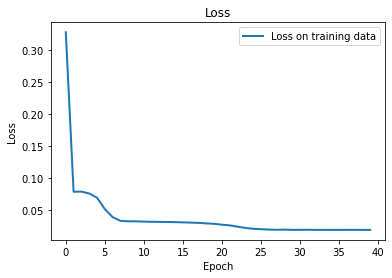

In [370]:
# you do not need to change the content of this cell

plt.plot(history, linewidth=2, label='Loss on training data')
plt.legend(loc='upper right')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [334]:
x=torch.tensor([[1,2,3],[4,5,6]])
y=torch.tensor([1,1,1])

print(torch.tensordot(x,y,1).shape)

torch.Size([2])
